This code trains an LSTM model to predict Amazon stock closing prices using historical data. The process involves reading and preprocessing the dataset, scaling the features, and reshaping the data for the LSTM. The data is then split into training and testing sets, and a custom PyTorch dataset and dataloaders are created. An LSTM model is defined, and a training loop is implemented to optimize the model using the Adam optimizer and MSE loss. After training, the model's predictions are plotted against actual values to visualize performance. The goal is to predict future stock prices based on past data using deep learning.

In [1]:
# Import necessary libraries for deep learning, data manipulation, and visualization
# Assuming further code involves deep learning model training or data preprocessing steps.
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Read the Amazon stock price data from a CSV file
dataset = pd.read_csv('./datasets/AMZN.csv')
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
3,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
4,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000


In [3]:
# Selecting 'Date' and 'Close' columns from the dataset
dataset = dataset[['Date', 'Close']]
dataset.head()

,Date,Close
0,1997-05-15,0.097917
1,1997-05-16,0.086458
2,1997-05-19,0.085417
3,1997-05-20,0.081771
4,1997-05-21,0.071354


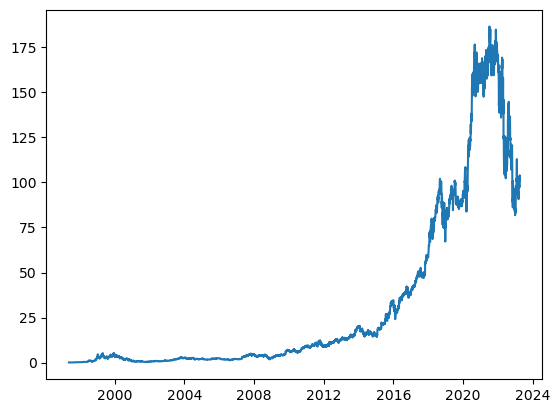

In [4]:
# Plotting the closing prices over time
plt.plot(pd.to_datetime(dataset['Date']), dataset['Close'])

In [15]:
# Prepares a dataset for time series forecasting by creating lagged features.

# Args:
# - dataset (pd.DataFrame): Original dataset with 'Date' and 'Close' columns.
# - n_steps (int): Number of lag steps to create.

# Returns:
# - pd.DataFrame: Transformed dataset with lagged features.\
def prepare_dataset(dataset, n_steps):
    dataset.set_index('Date',inplace=True)
    for i in range(1, n_steps+1):
        dataset[f"Close(t-{i})"] = dataset['Close'].shift(i)
    dataset.dropna(inplace=True)
    return dataset

look_back = 7
shifted_df = prepare_dataset(dataset, look_back)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
1997-05-27,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458,0.097917
1997-05-28,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458
1997-05-29,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417
1997-05-30,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771
1997-06-02,0.075521,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354
...,...,...,...,...,...,...,...,...
2023-03-30,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999,98.699997,100.610001
2023-03-31,103.290001,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999,98.699997
2023-04-03,102.410004,103.290001,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999


In [16]:
shifted_df_numpy = shifted_df.to_numpy()

scalar = MinMaxScaler(feature_range=(-1,1))
shifted_df_numpy = scalar.fit_transform((shifted_df_numpy))

shifted_df_numpy[:5]

array([[-0.99991063, -0.99995531, -1.        , -0.99998325, -0.99987154,
        -0.99983244, -0.99982128, -0.99969839],
       [-0.99993855, -0.99991063, -0.99994415, -1.        , -0.99998325,
        -0.99987154, -0.99983244, -0.99982128],
       [-0.99995253, -0.99993855, -0.99989946, -0.99994415, -1.        ,
        -0.99998325, -0.99987154, -0.99983244],
       [-0.99995531, -0.99995253, -0.99992739, -0.99989946, -0.99994415,
        -1.        , -0.99998325, -0.99987154],
       [-0.99994973, -0.99995531, -0.99994136, -0.99992739, -0.99989946,
        -0.99994415, -1.        , -0.99998325]])

In [17]:
# Extract features (X) and target (y) from the shifted dataset
# X =Features are all columns except the first (target)
# y=  Target is the first column
X = shifted_df_numpy[:, 1:]
y = shifted_df_numpy[:, 0]
print(X[1] , y[1])
print(X.shape, y.shape)

[-0.99991063 -0.99994415 -1.         -0.99998325 -0.99987154 -0.99983244
 -0.99982128] -0.999938552167786
(6509, 7) (6509,)


In [18]:
# Reverse the order of features along the time axis
X = np.flip(X, axis = 1).copy()
X

array([[-0.99969839, -0.99982128, -0.99983244, ..., -0.99998325,
        -1.        , -0.99995531],
       [-0.99982128, -0.99983244, -0.99987154, ..., -1.        ,
        -0.99994415, -0.99991063],
       [-0.99983244, -0.99987154, -0.99998325, ..., -0.99994415,
        -0.99989946, -0.99993855],
       ...,
       [ 0.05779984,  0.05158   ,  0.0506149 , ...,  0.07431453,
         0.09308121,  0.10690997],
       [ 0.05158   ,  0.0506149 ,  0.04203581, ...,  0.09308121,
         0.10691495,  0.09747299],
       [ 0.0506149 ,  0.04203581,  0.07431453, ...,  0.10691495,
         0.09747802,  0.11398769]])

In [19]:
# Determine the index to split the data into training and testing sets
split_index = int(len(X)*0.95)
split_index

6183

In [20]:
# Split the data into training and testing sets based on split_index

X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6183, 7), (326, 7), (6183,), (326,))

In [21]:
# Reshape the training and testing sets to fit LSTM model input requirements

X_train = X_train.reshape((-1, look_back,1))
X_test = X_test.reshape((-1, look_back, 1))

y_train = y_train.reshape((-1,1))
y_test = y_test.reshape((-1,1))
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6183, 7, 1), (326, 7, 1), (6183, 1), (326, 1))

In [22]:
# Convert NumPy arrays to PyTorch tensors and cast to float type
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()

In [23]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([6183, 7, 1]),
 torch.Size([326, 7, 1]),
 torch.Size([6183, 1]),
 torch.Size([326, 1]))

In [24]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

#Custom PyTorch dataset for time series data.

class TimeSeriesData(Dataset):
    #Initialize the dataset with features (X) and targets (y).

    def __init__(self, X,y):
        self.X = X
        self.y = y
    
    def __len__(self):
        #Return the number of samples in the dataset.

        return len(self.X)
    
    def __getitem__(self, index):
        # Retrieve a sample from the dataset by index.

        return self.X[index], self.y[index]

train_dataset = TimeSeriesData(X_train, y_train)
test_dataset = TimeSeriesData(X_test, y_test)


batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [25]:
# Iterate through the training data loader and print the shapes of the first batch
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0], batch[1]
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [26]:
#    LSTM (Long Short-Term Memory) model for time series forecasting.
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
    #input_size -Number of expected features in the input x.
    #hidden_size - Number of features in the hidden state h.
    #num_stacked_layers - Number of LSTM layers stacked on top of each other.
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [27]:
# Instantiate an LSTM model for time series forecasting

model = LSTM(input_size=1, hidden_size=4, num_stacked_layers=1)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [28]:
# Function to perform one training epoch on the LSTM model.

# It iterates through batches of data from the train_loader, computes the loss,
# and updates the model parameters using backpropagation.

# Prints average batch loss every 100 batches.
def train_one_epoch():
    model.train(True)
    print(f'Epoch count: {epoch+1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0], batch[1]

        # Forward pass: compute predicted outputs by passing inputs to the model
        output = model(x_batch)

        # Calculate the batch loss
        loss = loss_function(output, y_batch)

        # Accumulate the total loss
        running_loss += loss

        # Zero gradients, perform a backward pass, and update the weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

       # Print average loss every 100 batches
        if batch_index %100 ==99:
            avg_loss_accross_batch = running_loss/100
            print(f'Batch count: {batch_index+1}, Loss:{avg_loss_accross_batch}')
            

In [29]:
# Function to perform validation on the LSTM model for one epoch.

# It iterates through batches of data from the train_loader, computes the validation loss,
# and prints the average validation loss.
def validate_one_epoch():
     # Set the model in evaluation mode (no dropout or batch norm)
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0], batch[1]

 # Disable gradient calculation for validation
        with torch.no_grad():
 # Forward pass: compute predicted outputs by passing inputs to the model
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            # Accumulate the total loss
            running_loss += loss.item()

    # Calculate average validation loss across batches
    avg_loss_accross_batch = running_loss/100
    print(f'Validation Loss:{avg_loss_accross_batch}')
            

In [30]:
learning_rate = 0.001
epochs = 15
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr= learning_rate)

# Training loop over specified number of epochs
for epoch in range(epochs):
 # Perform one epoch of training
    train_one_epoch()
# Perform validation after each training epoch
    validate_one_epoch()

Epoch count: 1
Batch count: 100, Loss:0.9135465025901794
Batch count: 200, Loss:1.1611227989196777
Batch count: 300, Loss:1.2113717794418335
Validation Loss:0.04339140833122656
Epoch count: 2
Batch count: 100, Loss:0.007962693460285664
Batch count: 200, Loss:0.013550651259720325
Batch count: 300, Loss:0.01754743792116642
Validation Loss:0.015783162936277222
Epoch count: 3
Batch count: 100, Loss:0.004177567549049854
Batch count: 200, Loss:0.007694961968809366
Batch count: 300, Loss:0.01066492311656475
Validation Loss:0.010753183764172718
Epoch count: 4
Batch count: 100, Loss:0.002639847109094262
Batch count: 200, Loss:0.00520569970831275
Batch count: 300, Loss:0.007071643602102995
Validation Loss:0.006722947026719339
Epoch count: 5
Batch count: 100, Loss:0.0016947368858382106
Batch count: 200, Loss:0.003106851829215884
Batch count: 300, Loss:0.004180733114480972
Validation Loss:0.0037638170621357857
Epoch count: 6
Batch count: 100, Loss:0.0009674197644926608
Batch count: 200, Loss:0.001

In [31]:
# Use the trained LSTM model to predict values on the training data

with torch.no_grad():
    predicted_values = model(X_train).numpy()


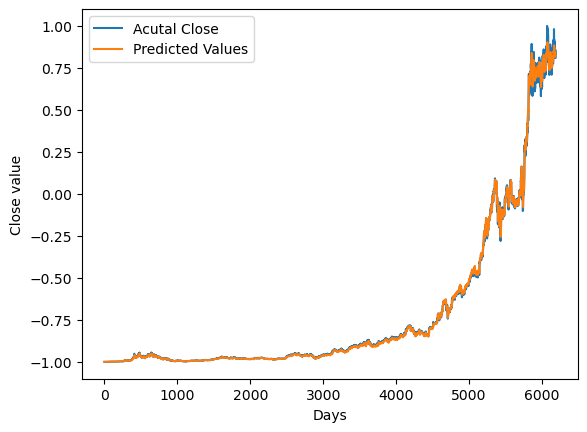

In [32]:
# Plotting actual vs predicted values for the training data

plt.plot(y_train, label = 'Acutal Close')
plt.plot(predicted_values, label = 'Predicted Values')
plt.xlabel("Days")
plt.ylabel('Close value')
plt.legend()
plt.show()

In [33]:
# Flatten predicted values and transform back using the scaler
train_prediction = predicted_values.flatten()
# Create a zeros array with appropriate shape
dummies = np.zeros((X_train.shape[0], look_back+1))
# Assign flattened predicted values to the first column
dummies[:,0] =train_prediction

# Inverse transform using the scaler
dummies = scalar.inverse_transform(dummies)

# Extract transformed predicted values
train_prediction = dummies[:,0]
train_prediction

array([1.34768090e-01, 1.35501762e-01, 1.35557343e-01, ...,
       1.70092929e+02, 1.69396196e+02, 1.70044740e+02])

In [34]:
# Generate predictions on the test data and transform back using the scaler
test_predictions = model(X_test).detach().numpy().flatten()
dummies = np.zeros((X_test.shape[0], look_back+1))
dummies[:, 0] = y_test.flatten()
dummies = scalar.inverse_transform(dummies)
test_predictions = dummies[:,0].copy()
test_predictions


array([170.01749949, 167.07899763, 170.41700626, 171.03700377,
       171.0684961 , 169.66949429, 170.66099675, 169.20100565,
       168.64449858, 166.71699707, 170.40449492, 167.52200227,
       164.35699578, 163.25399737, 162.55400179, 161.48599177,
       165.36199892, 165.20699954, 161.21400501, 162.13799851,
       158.91749416, 156.29899568, 151.66749509, 142.64300408,
       144.54400445, 139.98599336, 138.87249844, 139.63749627,
       143.97799855, 149.57350001, 151.19349835, 150.61250219,
       138.84550541, 157.63949825, 157.93550165, 161.41349717,
       161.18949925, 159.003495  , 153.29350176, 155.1670061 ,
       156.51049894, 158.10049453, 154.6524962 , 152.60149876,
       150.19749381, 144.82699629, 151.35800212, 153.78849709,
       153.56300403, 151.14199678, 152.05250627, 147.89849848,
       145.64100565, 137.45300383, 136.01449488, 139.27900567,
       146.81750468, 145.52450739, 141.8529947 , 147.36650272,
       153.10400311, 157.23899657, 161.25050521, 161.49

In [35]:
# Prepare new_y_test by inverse transforming y_test using the scaler
# Create a zeros array with appropriate shape
dummies = np.zeros((X_test.shape[0], look_back+1))
# Assign flattened actual test values to the first column
dummies[:, 0] = y_test.flatten()
 # Inverse transform using the scaler
dummies = scalar.inverse_transform(dummies)
# Extract and copy transformed values to new_y_test
new_y_test = dummies[:,0].copy()
print(new_y_test)

[170.01749949 167.07899763 170.41700626 171.03700377 171.0684961
 169.66949429 170.66099675 169.20100565 168.64449858 166.71699707
 170.40449492 167.52200227 164.35699578 163.25399737 162.55400179
 161.48599177 165.36199892 165.20699954 161.21400501 162.13799851
 158.91749416 156.29899568 151.66749509 142.64300408 144.54400445
 139.98599336 138.87249844 139.63749627 143.97799855 149.57350001
 151.19349835 150.61250219 138.84550541 157.63949825 157.93550165
 161.41349717 161.18949925 159.003495   153.29350176 155.1670061
 156.51049894 158.10049453 154.6524962  152.60149876 150.19749381
 144.82699629 151.35800212 153.78849709 153.56300403 151.14199678
 152.05250627 147.89849848 145.64100565 137.45300383 136.01449488
 139.27900567 146.81750468 145.52450739 141.8529947  147.36650272
 153.10400311 157.23899657 161.25050521 161.49149987 164.8890082
 163.4080074  163.64950785 164.77349929 168.99049174 169.31500275
 166.30099379 162.99749555 163.55999984 168.34649425 164.05499516
 158.75599734

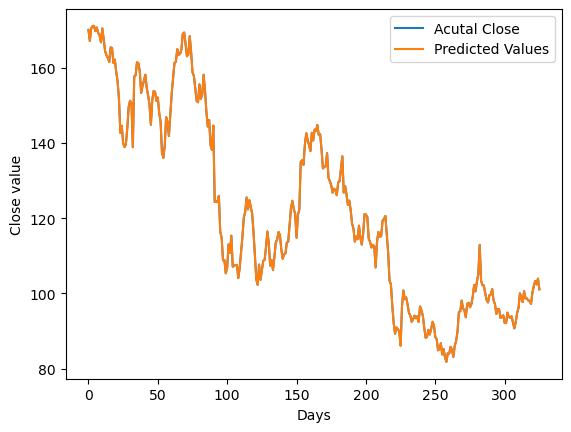

In [36]:
# Plotting actual vs predicted values for the test data

# Plot actual close values
plt.plot(new_y_test, label = 'Acutal Close')

 # Plot predicted values
plt.plot(test_predictions, label = 'Predicted Values')
plt.xlabel("Days")
plt.ylabel('Close value')
plt.legend()
plt.show()